In [40]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional

class DataProcessor:
    def __init__(self, api: wandb.Api):
        self.api = api
        self.keys = [
            "validation_in_domain/accuracy",
            "training/accuracy"
        ]
    
    def get_run_data(self, run_path: str) -> pd.DataFrame:
        """Fetch and process run data from W&B."""
        run = self.api.run(f"philliplakaschus/grokking/{run_path}")
        
        history = list(run.scan_history())
        if not history:
            raise ValueError(f"No data found for run: {run_path}")
            
        available_columns = set(history[0].keys())
        requested_cols = ['Optimization Steps'] + self.keys
        cols_to_fetch = [col for col in requested_cols if col in available_columns]
        
        if not cols_to_fetch:
            raise ValueError(f"None of the required columns found in run: {run_path}")
            
        steps = pd.DataFrame([
            {k: step.get(k) for k in cols_to_fetch}
            for step in run.scan_history(cols_to_fetch)
        ])
        
        df = pd.DataFrame({
            'training/accuracy': steps['training/accuracy'].values,
            'validation_in_domain/accuracy': steps['validation_in_domain/accuracy'].values,
        }, index=steps['Optimization Steps'])
                
        return df
    
    @staticmethod
    def apply_ema(df: pd.DataFrame, alpha: float = 0.3) -> pd.DataFrame:
        """Apply Exponential Moving Average smoothing."""
        return df.ewm(alpha=alpha, adjust=False).mean()

class GridPlotter:
    def __init__(self):
        self.colors = {
            'classification': {
                'training': '#b00000',    # dark red
                'validation': '#fc0303'    # bright red
            },
            'seq2seq': {
                'training': '#013491',     # dark blue
                'validation': '#0259fa'    # bright blue
            }
        }
    
    def plot_task_comparison(self, ax: plt.Axes, class_df: pd.DataFrame, 
                           seq2seq_df: pd.DataFrame, task_name: str) -> None:
        """Plot comparison for a single task."""
        
        max_steps = 12000
        class_df = class_df[class_df.index <= max_steps]
        seq2seq_df = seq2seq_df[seq2seq_df.index <= max_steps]
        
        # Plot classification curves
        ax.plot(class_df.index, class_df['training/accuracy'],
                color=self.colors['classification']['training'], linewidth=2,
                label='Class Training')
        ax.plot(class_df.index, class_df['validation_in_domain/accuracy'],
                color=self.colors['classification']['validation'], linewidth=2,
                label='Class Validation', linestyle='--')
        
        # Plot seq2seq curves
        ax.plot(seq2seq_df.index, seq2seq_df['training/accuracy'],
                color=self.colors['seq2seq']['training'], linewidth=2,
                label='Seq2Seq Training')
        ax.plot(seq2seq_df.index, seq2seq_df['validation_in_domain/accuracy'],
                color=self.colors['seq2seq']['validation'], linewidth=2,
                label='Seq2Seq Validation', linestyle='--')
        
        # Style the subplot
        ax.set_facecolor('#f8f9fa')
        ax.grid(True, which='major', linestyle='--', alpha=0.7, color='#cccccc')
        ax.set_xlabel('Optimization Steps', fontsize=12, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax.set_title(task_name.replace('_', ' ').title(), fontsize=12, fontweight='bold', pad=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        ax.set_ylim(-0.05, 1.05)
        ax.legend(loc='lower right', frameon=True, fancybox=True, 
                 shadow=True, fontsize=8)
    
    def create_grid_comparison(self, classification_data: Dict[str, pd.DataFrame],
                             seq2seq_data: Dict[str, pd.DataFrame],
                             task_order: Optional[List[str]] = None) -> None:
        """Create grid of task comparisons."""
        plt.style.use('default')
        
        # Create figure with 2 rows: 3 plots in first row, 2 in second row
        fig = plt.figure(figsize=(20, 12), dpi=150)
        gs = fig.add_gridspec(2, 3, height_ratios=[1, 1])
        
        # If task_order not specified, use sorted keys
        if task_order is None:
            task_order = sorted(classification_data.keys())
        
        # Create subplots and plot data
        for idx, task in enumerate(task_order):
            # Position plots: first 3 in top row, last 2 in bottom row
            if idx < 3:
                ax = fig.add_subplot(gs[0, idx])
            else:
                ax = fig.add_subplot(gs[1, idx - 3])
            
            self.plot_task_comparison(
                ax,
                classification_data[task],
                seq2seq_data[task],
                task
            )
            
        # Adjust layout
        fig.patch.set_facecolor('#ffffff')
        plt.tight_layout()
        return fig

def run_grid_comparison(api: wandb.Api,
                       classification_urls: Dict[str, str],
                       seq2seq_urls: Dict[str, str]) -> None:
    processor = DataProcessor(api)
    plotter = GridPlotter()
    
    # Process all runs
    classification_data = {}
    seq2seq_data = {}
    
    print("Processing classification runs...")
    for task, run_id in classification_urls.items():
        run_id = run_id.split('/')[-1]  # Extract just the run ID
        df = processor.get_run_data(run_id)
        classification_data[task] = processor.apply_ema(df)
    
    print("Processing seq2seq runs...")
    for task, run_id in seq2seq_urls.items():
        run_id = run_id.split('/')[-1]  # Extract just the run ID
        df = processor.get_run_data(run_id)
        seq2seq_data[task] = processor.apply_ema(df)
    
    # Define task order for consistent layout
    task_order = ['x,y_abs_diff', 'x,y_sqrt', 'x,y_avg', 'x,y_abs_min', 'x,y_abs_max']
    
    # Create plots
    plotter.create_grid_comparison(
        classification_data,
        seq2seq_data,
        task_order=task_order
    )
    plt.show()

In [41]:
api = wandb.Api()


# New Grokking Tasks

In [42]:
classification_urls = {"x,y_abs_diff": "philliplakaschus/grokking/7ha0ai1c", "x,y_sqrt":"philliplakaschus/grokking/t6237ooe", "x,y_avg": "philliplakaschus/grokking/1nezj4ge", "x,y_abs_min": "philliplakaschus/grokking/y7ol4x8g", "x,y_abs_max": "philliplakaschus/grokking/n4uf6bno"}
seq2seq_urls = {"x,y_sqrt": "philliplakaschus/grokking/8ffb8kb3", "x,y_avg": "philliplakaschus/grokking/j8s5v94c", "x,y_abs_min": "philliplakaschus/grokking/c1fz8icd", "x,y_abs_max": "philliplakaschus/grokking/rrq9f1hy", "x,y_abs_diff": "philliplakaschus/grokking/9rqskufj"}

Processing classification runs...
Processing seq2seq runs...


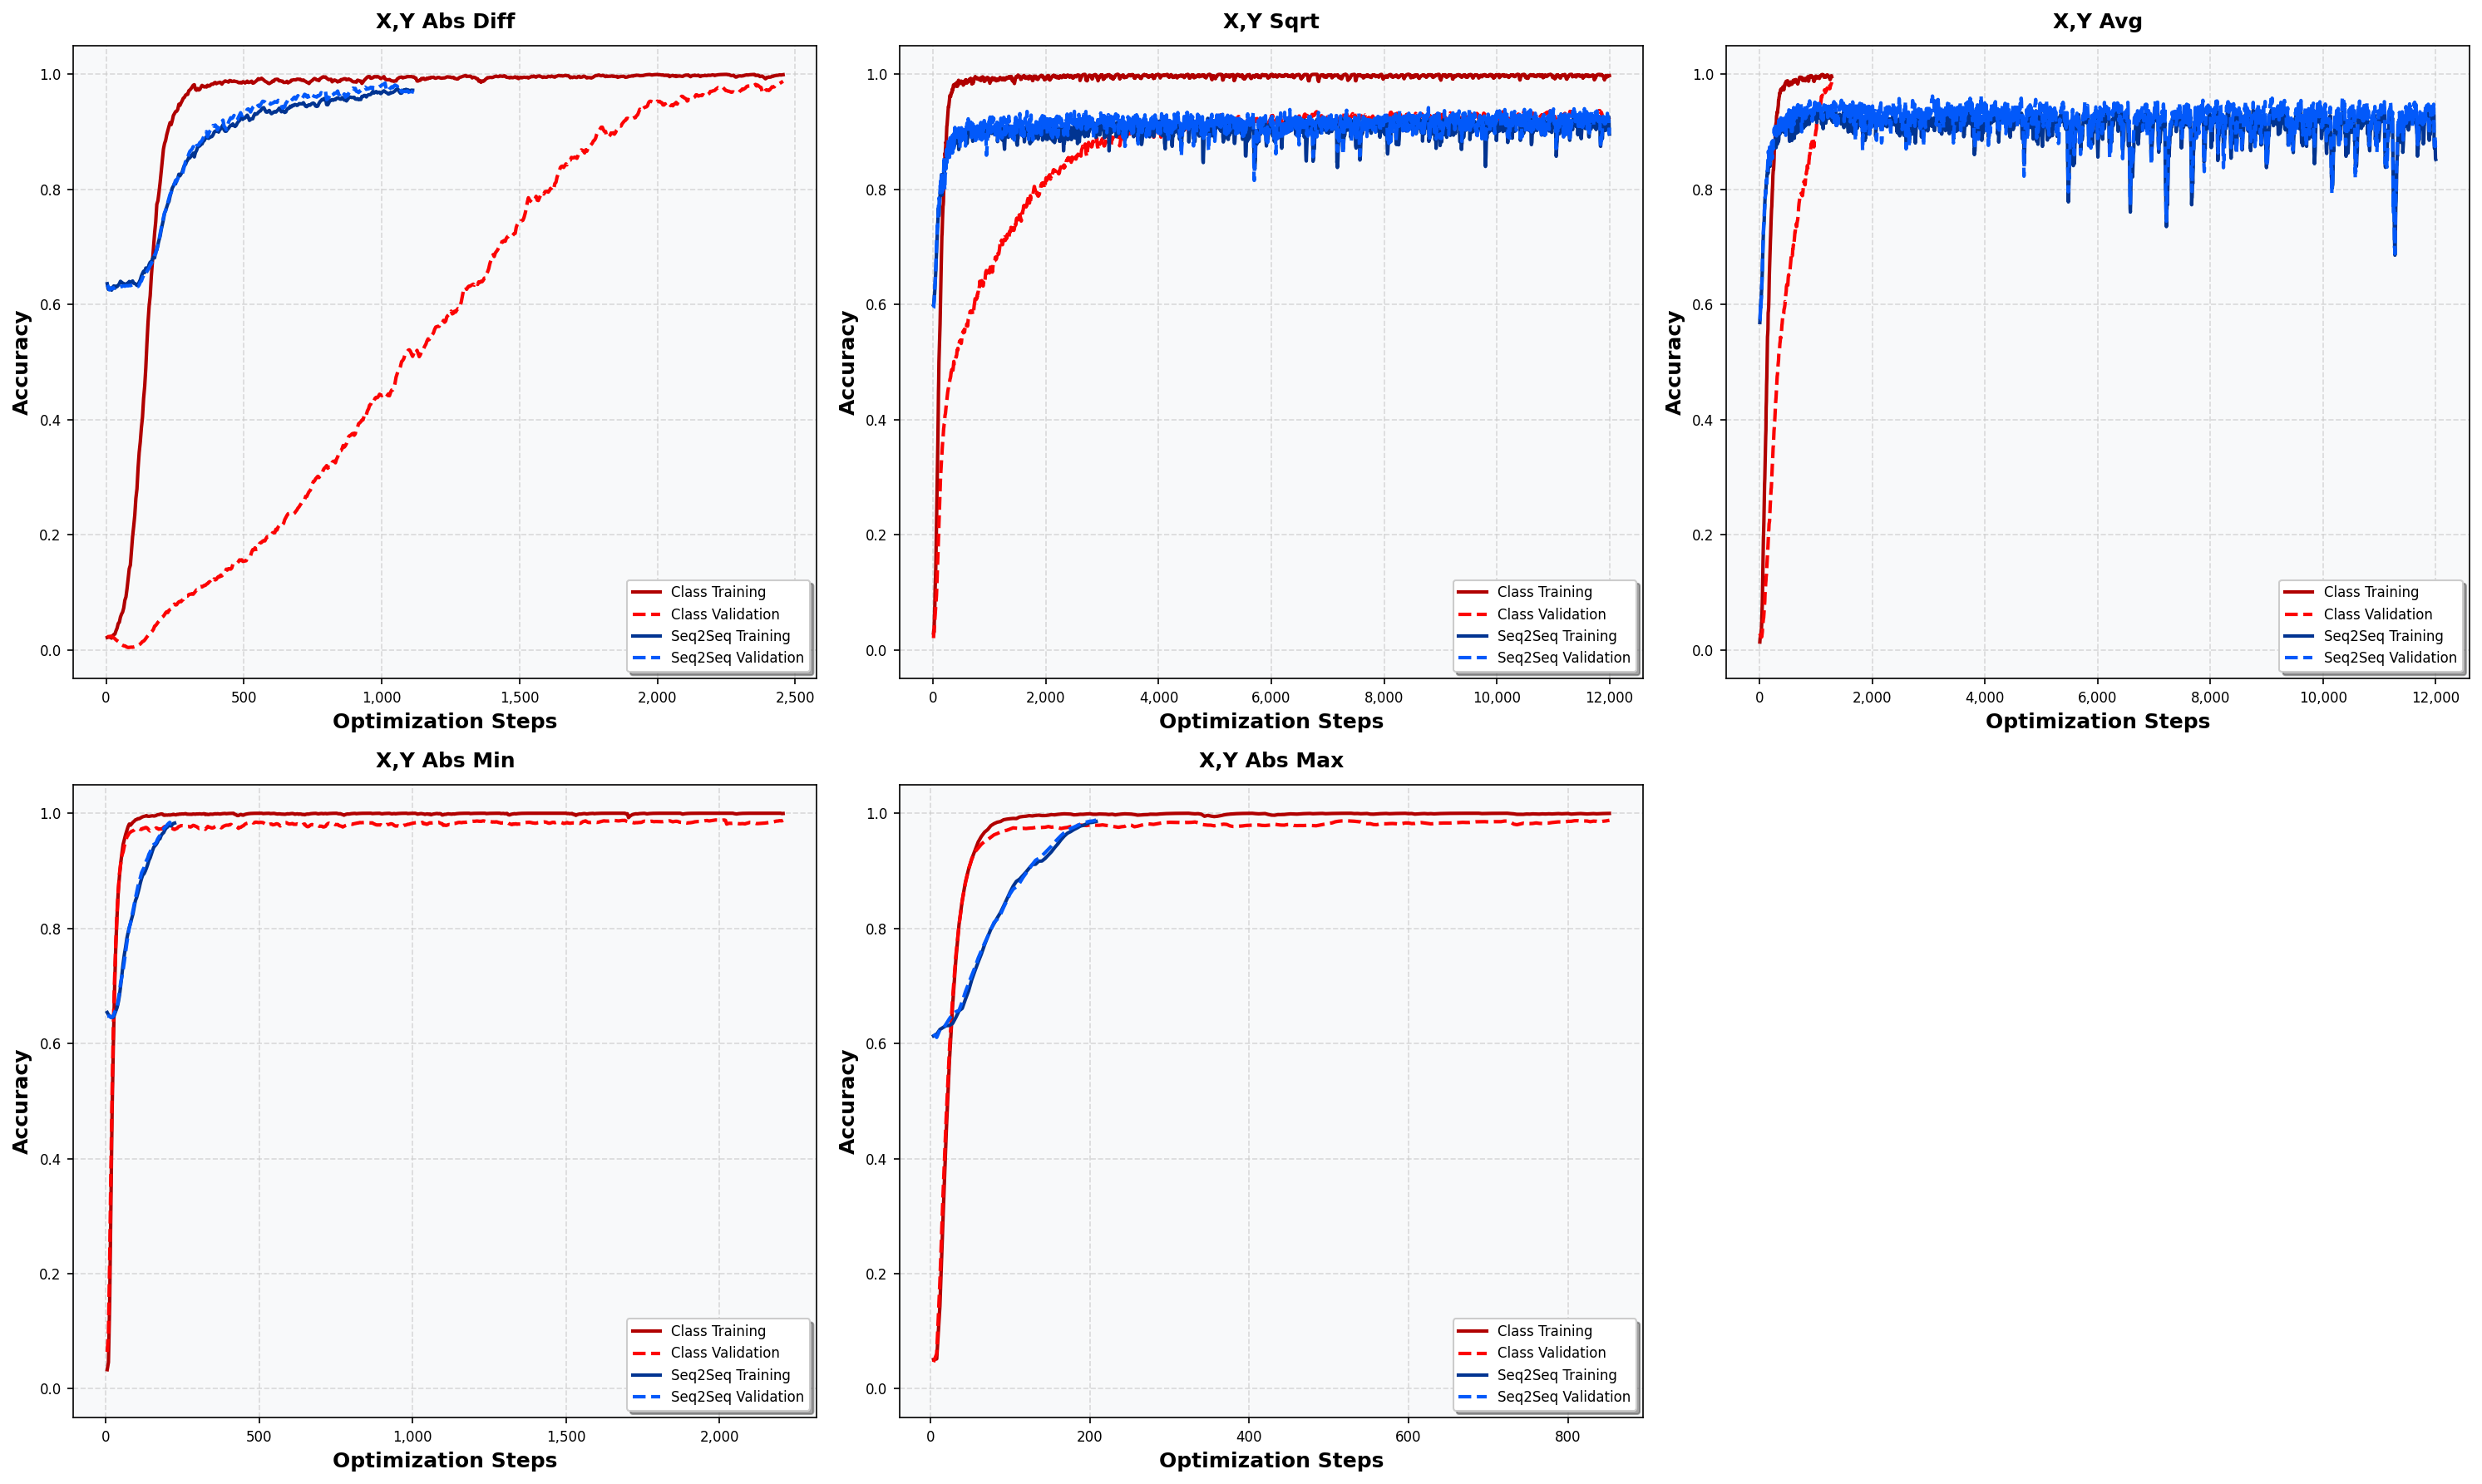

In [43]:
# Run the comparison
api = wandb.Api()
run_grid_comparison(
    api,
    classification_urls=classification_urls,
    seq2seq_urls=seq2seq_urls
)